Import the data set of the store information.

In [22]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import utility as utl
import re
from IPython.display import display
from sklearn import preprocessing, ensemble
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, validation_curve
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from math import sqrt
%matplotlib inline

# import data
store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')

Convert date time to features:

In [2]:
# cahnge the data format of the date
data_transactiondate = train_data['Date'].tolist()
year = []
month = []
date = []

for i in data_transactiondate:
    year.append(int(i[0:4]))
    month.append(int(i[5:7]))
    date.append(int(i[8:10]))
        
date_data = pd.DataFrame({'year':year, 'month':month, 'date':date}, columns = ['year', 'month', 'date'])
train_data.drop(['Date'], axis=1, inplace=True)
date_concat = pd.concat([train_data, date_data], axis=1)
train_data = date_concat

merge_data = pd.merge(store_data, train_data, on='Store', how='outer')
merge_data_1 = pd.merge(store_data, train_data, on='Store', how='outer')

storemode_list = []
for i in range(len(store_data.index)):
    j = store_data['StoreType'].loc[i]
    k = store_data['Assortment'].loc[i]
    storemode_list.append(j + k)

# storemode = pd.DataFrame(storemode_list, columns=['storemode'])

# storemode['Store'] = storemode.index 
# merge_data = pd.merge(merge_data, storemode, on='Store', how='outer')

merge_data = merge_data[(merge_data['Sales'].notnull())]

# remove all rows that were closed 
merge_data = merge_data[merge_data['Open'] != 0]

sales = merge_data['Sales']

# drop unnecessary columns
merge_data.drop(['Sales', 'Customers']
                 , axis=1, inplace=True)

merge_data.drop(['year'], axis=1, inplace=True)

# drop store column
merge_data.drop(['Store'], axis=1, inplace=True)
merge_data.drop(['date'], axis=1, inplace=True)


In [3]:
# use median to replace NaN for numerical column
numeric_column_heads = ['Promo2SinceYear', 'CompetitionDistance', 'CompetitionOpenSinceYear',
                        'month', 'DayOfWeek', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek']
numeric_columns = merge_data[numeric_column_heads]
categorical_columns = merge_data.drop(numeric_column_heads, axis=1)

imputer = Imputer(strategy='median')
imputer.fit(numeric_columns)
numeric_columns_X = imputer.transform(numeric_columns)
numeric_columns_tr = [pd.DataFrame(numeric_columns_X, columns=numeric_column_heads)]

categorical_columns.fillna('nan', inplace=True)
categorical_columns_tr = []
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
for h in categorical_columns:
    col_encoded = label_encoder.fit_transform(categorical_columns[h])
    col_1hot = one_hot_encoder.fit_transform(col_encoded.reshape(-1, 1))
    col = pd.DataFrame(col_1hot.toarray())
    col = col.add_prefix(h)
    categorical_columns_tr.append(col)
    
features = pd.concat(numeric_columns_tr + categorical_columns_tr, axis=1)

/Users/yen/Library/Python/2.7/lib/python/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/yen/Library/Python/2.7/lib/python/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
# normalize
x = features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled, columns=features.columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, sales, test_size = 0.2, random_state = 0)

In [6]:
# ML Regressor
regressor = DecisionTreeRegressor(random_state=0)
scorer = make_scorer(utl.performance_metric)

In [8]:
# Gird search
params =  {'min_samples_leaf':range(4,10),
           'max_depth': range(33,45,2)
          }
best_result = utl.GirdSearch(x_train, y_train, regressor, params)
print best_result

DecisionTreeRegressor(criterion='mse', max_depth=39, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


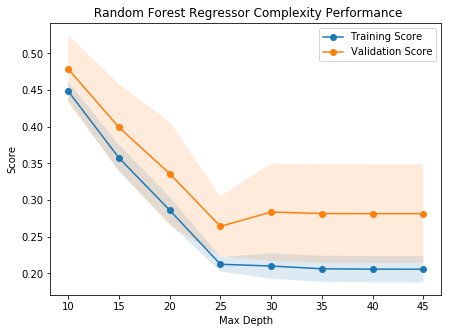

In [8]:
# Plot ModelComplexity
param_range = np.arange(10,46,5)
plot_title = ' Decision Tree Regressor Complexity Performance'
xlabel = 'Max Depth'
regressor = DecisionTreeRegressor(min_samples_leaf=7, random_state=0)

utl.ModelComplexity(x_train, y_train, regressor, 'max_depth', param_range, xlabel, plot_title, scorer)

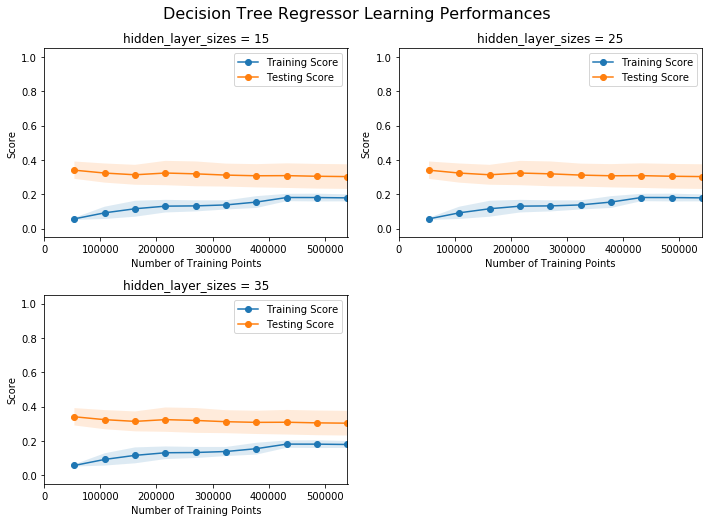

In [8]:
# Model learning performances
suptitle = 'Decision Tree Regressor Learning Performances'
train_sizes = np.linspace(.1, 1.0, 10)
plot_con = [15, 25, 35, 45]
utl.ModelLearning(x_train, y_train, suptitle, plot_con, train_sizes, scorer, regressor)

In [10]:
best_regressor = DecisionTreeRegressor(max_depth=25, min_samples_leaf=7, random_state=0)
best_regressor.fit(x_train, y_train)
y_predict = best_regressor.predict(x_test)
dt_score = utl.performance_metric(y_test, y_predict)

scores = cross_val_score(best_regressor, x_train, y_train, cv=10, scoring=scorer)
avg_scores = sum(scores) / len(scores)
print 'Validation Score' + str(avg_scores)

Validation Score0.236680206859


In [40]:
print best_regressor.feature_importances_

[  2.57059066e-02   2.89666022e-01   1.22084308e-01   4.15224836e-02
   7.22534646e-02   9.46553537e-02   4.29141089e-02   1.84687170e-02
   2.75193840e-02   1.18653310e-02   9.28812997e-03   9.06017618e-03
   2.24641089e-04   2.20110581e-02   9.95162558e-03   7.90554191e-03
   2.68926178e-03   1.28633901e-02   1.03221167e-02   4.30752679e-03
   0.00000000e+00   1.56541280e-01   0.00000000e+00   6.48614835e-04
   7.03791267e-04   5.27597561e-04   4.31186429e-05   6.80176364e-06
   1.82689850e-03   4.42334973e-03]


Train with AdaBoost

In [30]:
reg_ada = AdaBoostRegressor(random_state=0)
reg_name = 'Boosting Classifier'

In [38]:
# Gird search
params =  {'n_estimators' : range(40, 100, 20),
           'base_estimator' : [DecisionTreeRegressor(max_depth=25, min_samples_leaf=7, random_state=0),
                              DecisionTreeRegressor(max_depth=30, min_samples_leaf=7, random_state=0),
                              DecisionTreeRegressor(max_depth=40, min_samples_leaf=7, random_state=0),
                              DecisionTreeRegressor(max_depth=50, min_samples_leaf=7, random_state=0)]
          }

# Fit model
best_result = utl.GirdSearch(x_train, y_train, reg_ada, params)

In [39]:
print best_result

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=40, random_state=0)


In [37]:
reg_ada = AdaBoostRegressor(n_estimators=60,base_estimator=DecisionTreeRegressor(max_depth=40, min_samples_leaf=7, random_state=0),random_state=0)
reg_ada.fit(x_train, y_train)
y_predict = reg_ada.predict(x_test)
dt_score = utl.performance_metric(y_test, y_predict)

scores = cross_val_score(best_regressor, x_train, y_train, cv=10, scoring=scorer)
avg_scores = sum(scores) / len(scores)
print 'Validation Score' + str(avg_scores)

0.178602902514
